In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(rc={'figure.figsize': [14, 8]})
import plotly.express as px

import pickle
import re
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

from utils import categories

In [2]:
dfs = {}
dfs['data'] = pd.read_csv('data/LOCO/LOCO10k.csv')
dfs['data'].head(3)

,Unnamed: 0,doc_id,URL,website,seeds,date,subcorpus,title,txt,txt_nwords,...,txt_nparagraphs,topic_k100,topic_k200,topic_k300,mention_conspiracy,conspiracy_representative,cosine_similarity,FB_shares,FB_comments,FB_reactions
0,23258,C07120,https://oye.news/news/world-news/tanzania-pres...,oye.news,aids; covid.19; new.world.order,2020-05-06,conspiracy,Tanzania President Tested New CV-19 Test Kits ...,President Magufuli says tests were found to be...,249,...,5,k100_72,k200_52,k300_27,0,0.0,0.1138,17.0,11.0,44.0
1,70403,M179e0,https://www.independent.co.uk/news/world/ameri...,independent.co.uk,september.11.attack,2018-09-09,mainstream,New York subway station destroyed in 9/11 reop...,"After almost two decades out of action, a New ...",410,...,10,k100_79,k200_62,k300_72,0,NaN,NaN,67.0,115.0,617.0
2,41629,M0d77d,https://carrcenter.hks.harvard.edu/news/nras-w...,harvard.edu,sandy.hook,NaN,mainstream,The NRA's Worst Nightmare,"Shannon Watts, founder of Moms Demand Action, ...",199,...,1,k100_97,k200_141,k300_290,0,NaN,NaN,0.0,0.0,0.0


# Exploratory Analysis

<AxesSubplot: >

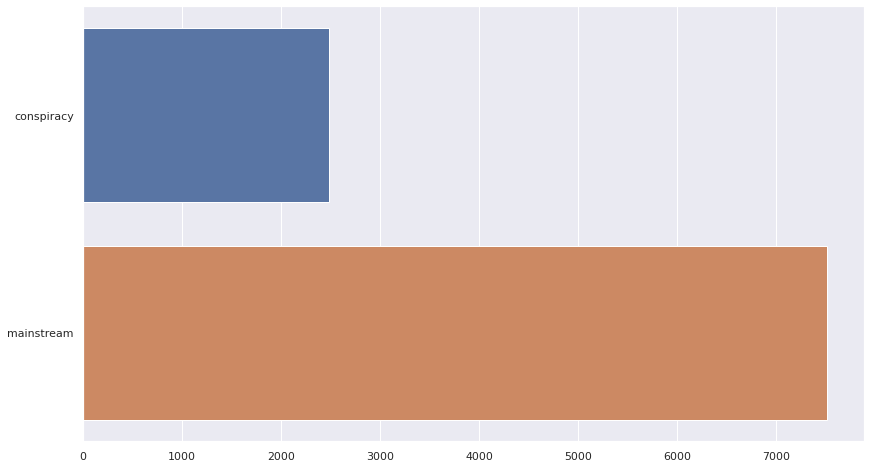

In [3]:
vals, counts = np.unique(dfs['data'].subcorpus, return_counts=True)
sns.barplot(x=counts, y=vals)

<AxesSubplot: xlabel='title', ylabel='Count'>

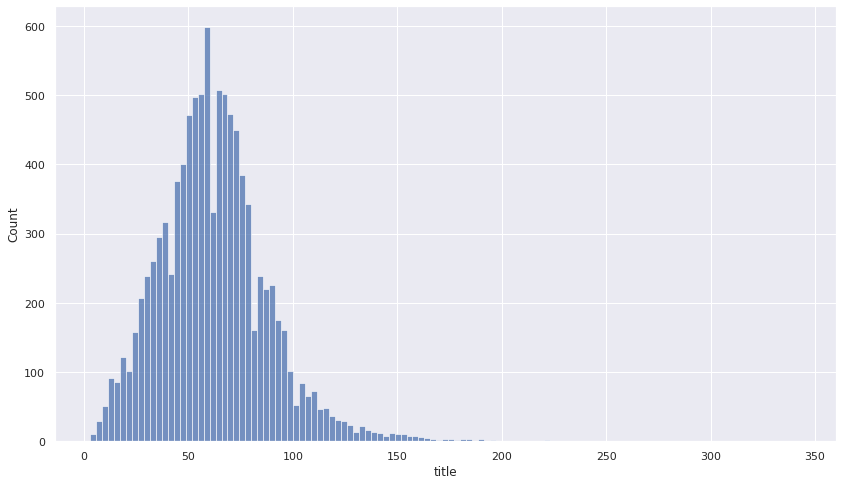

In [4]:
sns.histplot(dfs['data'].title.str.len())

<AxesSubplot: xlabel='txt_nwords', ylabel='Count'>

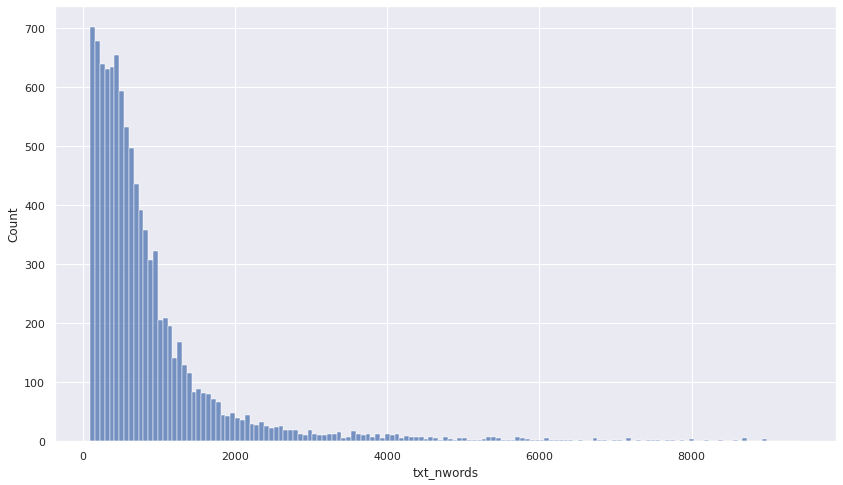

In [5]:
sns.histplot(dfs['data'].txt_nwords)

# Frames

In [6]:
with open('data/LOCO/loco_predictions.pickle', 'rb') as f:
    frames = pickle.load(f)

In [7]:
dfs['frames'] = pd.DataFrame(frames, columns=categories, index=dfs['data'].index, dtype=np.int32)
dfs['data'] = dfs['data'].join(dfs['frames'])

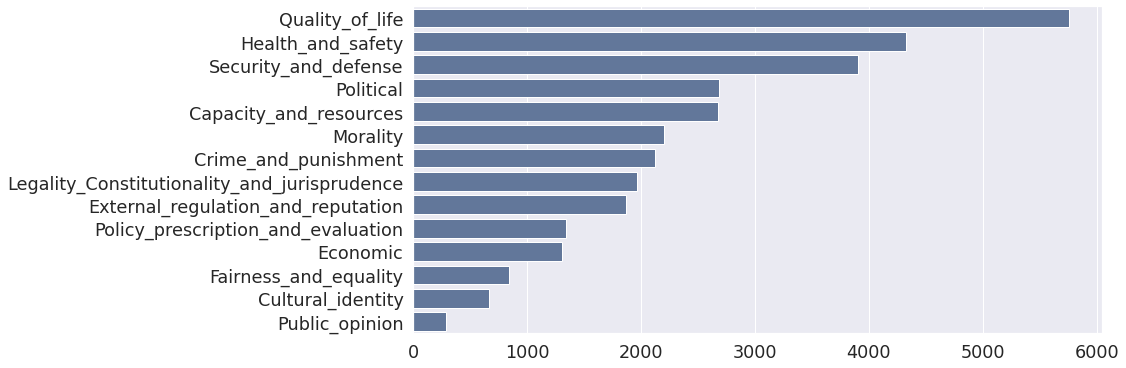

In [8]:
label_counts = dfs['data'][categories].sum(axis=0)
label_array = pd.DataFrame({"count": label_counts, "labels": categories})
order = np.argsort(label_counts)[::-1]
sns.set(font_scale=1.6)
plt.subplots(figsize=(16, 5.5))
sns.barplot(
    x="count",
    y="labels",
    data=label_array.iloc[order],
    color='#62779a',
    saturation=1.
).set(xlabel='', ylabel='')
plt.tight_layout()
#plt.savefig('figures/loco_frame_counts.pdf')
sns.set(font_scale=1)

In [9]:
selector = dfs['data'].subcorpus == 'mainstream'
label_counts = dfs['data'][selector][categories].sum(axis=0)
label_counts /= selector.sum()

selector = dfs['data'].subcorpus == 'conspiracy'
label_counts_con = dfs['data'][selector][categories].sum(axis=0)
label_counts_con /= selector.sum()

dfs['relative_frame_counts'] = pd.DataFrame([label_counts, label_counts_con], index=['Mainstream', 'Conspiracy']).T

<AxesSubplot: xlabel='Frame %', ylabel='Frame'>

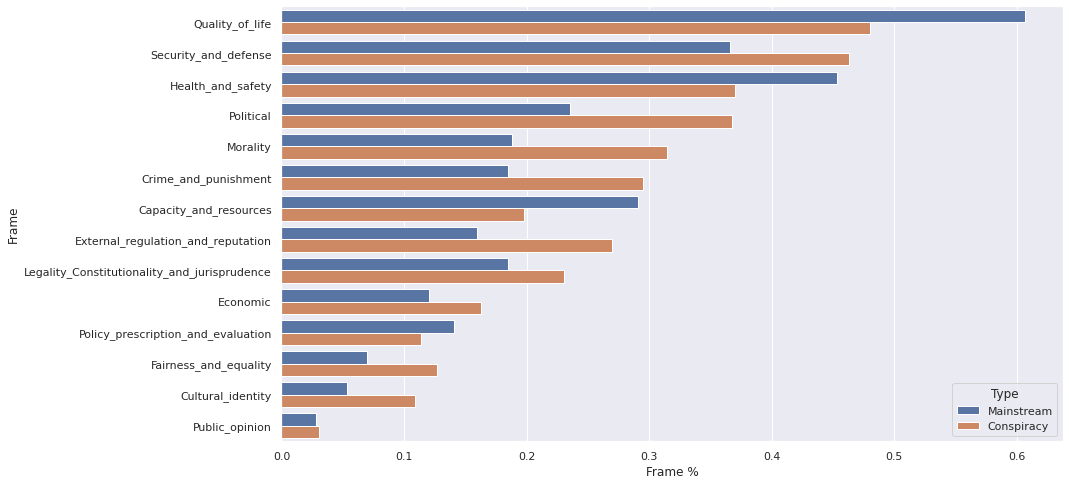

In [10]:
dfs['relative_frame_counts']['Frame'] = dfs['relative_frame_counts'].index
sns.barplot(dfs['relative_frame_counts'].melt(id_vars='Frame', value_name='Frame %', var_name='Type').sort_values(by='Frame %', ascending=False), x='Frame %', y='Frame', hue='Type')

# Topic Coherence Measure

In [11]:
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score

In [12]:
def calculate_feature_importance(X, labels, vocabulary, cat, n_words=30, min_coefficient=1):
    model = LogisticRegression(fit_intercept=False, penalty='l1', solver='liblinear')
    model.fit(X, labels)
    f1score = f1_score(model.predict(X), labels)
    print('MicroF1: ', f1score)
    
    min_coefficients = np.argsort(model.coef_[0])
    max_coefficients = min_coefficients[::-1]
    
    print('Positive: ', vocabulary[max_coefficients[:n_words]])
    print('Negative: ', vocabulary[min_coefficients[:n_words]])
    
    coefficients = model.coef_[model.coef_ != 0]
    sns.histplot(coefficients).set_title(f'{cat} - {len(coefficients)} Non-Zero Coefficients')
    plt.show()
    
    n_words_positive = np.sum(model.coef_[0] > 0.)
    n_words_negative = np.sum(model.coef_[0] < 0.)

    return vocabulary[max_coefficients[:n_words_positive]], vocabulary[min_coefficients[:n_words_negative]], f1score

In [13]:
#vectorizer = TfidfVectorizer(lowercase=False)
vectorizer = TfidfVectorizer(min_df=0.001, ngram_range=(1,3), stop_words='english')
X = vectorizer.fit_transform(dfs['data'].txt)
vocabulary = np.array(list(vectorizer.vocabulary_.keys()))

MicroF1:  0.6581896551724139
Positive:  ['ga' '244' 'percentage' 'used treat' 'lifts' 'tenuous' 'blindness' '1956'
 'does people' 'detects' 'dramatic increase' 'said knew' 'internal organs'
 'student loan' '1812' 'leasing' 'hasty' 'god saviour jesus' 'walters'
 'sheep' '2020 campaign' 'sculptor' 'general public' 'financial incentive'
 'wage' 'people probably' 'political ideology' 'referral' 'provocation'
 'slapping']
Negative:  ['success story' 'help lower' 'following statement' 'harmed'
 'documentation' 'anthem' 'measles outbreaks' 'profoundly' 'converging'
 'rationality' 'los angeles police' 'parasite' 'mick jagger' 'state colin'
 'tupelo mississippi' 'caused novel' 'exampled numerous'
 'treatment centres' 'st john' 'italian prime minister' 'cares act'
 'blogspot' 'lakh' 'fostering' 'madness' 'denials' 'impossibility'
 'parents child' 'straight line' 'heart surgery']


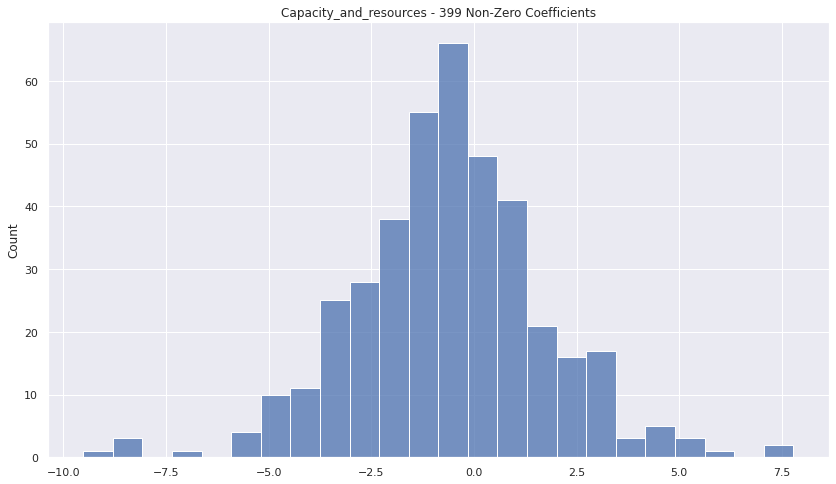

MicroF1:  0.7113654946852004
Positive:  ['foot long' 'shock' 'vulnerability' '25 30' 'straight line'
 'success story' 'sifting' 'federal law' 'strong' 'previous record'
 'services committee' 'help lower' 'live virus' '891' 'madness'
 'gulf region' 'ensemble' 'multiples' 'european leaders' 'million miles'
 'american space' 'university research' 'untrue' 'trolls' 'possess'
 'inches' 'authority' 'just finished' 'presidential nominee'
 'health defense']
Negative:  ['miami' 'hodgkin lymphoma' 'internal organs' 'iterations' 'walters'
 'latent' 'acutely aware' 'levin' 'sculptor' 'mass genocide' 'milo'
 'infect human' 'heavens' 'pandemic influenza' 'vitamin' 'alkaline' 'pea'
 'smartphones' 'plane said' 'february 2004' 'eyes nose mouth' 'glaring'
 'help build' 'johnny' '88' 'according internal' 'ahmed' 'used treat'
 'energy energy' 'parade']


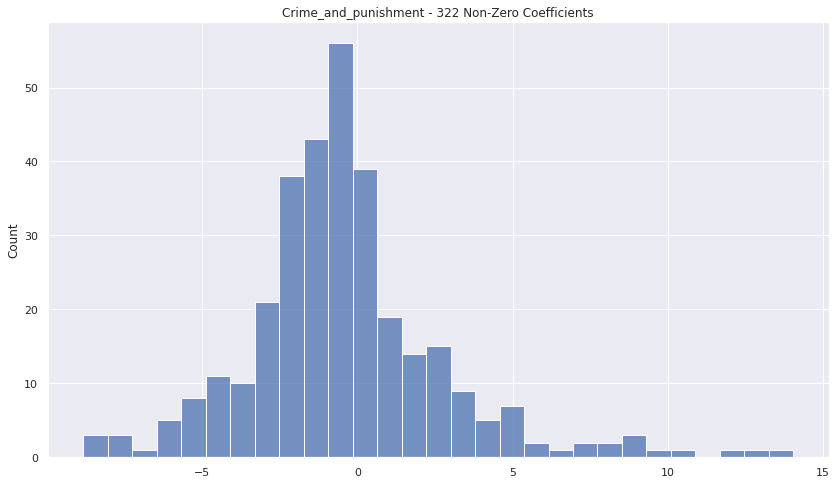

MicroF1:  0.20351758793969849
Positive:  ['trump win' 'tower world trade' 'sea levels' 'share information'
 'air temperature' 'perpetrated' 'caused novel' 'inputs' 'feeders'
 'ecuador' 'earth surface' '12 year old' 'lateral' 'backers'
 'change policy' 'proportions' 'tried unsuccessfully'
 'senate intelligence' 'credible data' 'people use' 'research suggests'
 'late 2017' 'vessels' 'los angeles police' 'did mention' 'transfusions'
 'equator' 'poly' 'denials' 'make effort']
Negative:  ['anti malarial' 'join sorcha' 'glaring' 'levin' 'countries risk'
 'parents child' 'decrees' 'common symptoms' 'converging' 'manned space'
 'plane said' 'warfare' 'million miles' 'music videos' 'changing climate'
 'financier george soros' 'infect human' 'february 2004' 'usama bin laden'
 'acrimonious' 'man giant' 'days attacks' 'inner' 'enhancing'
 'anti terrorist' 'people waiting' 'walters' 'life planets' 'carol'
 'prime minister benjamin']


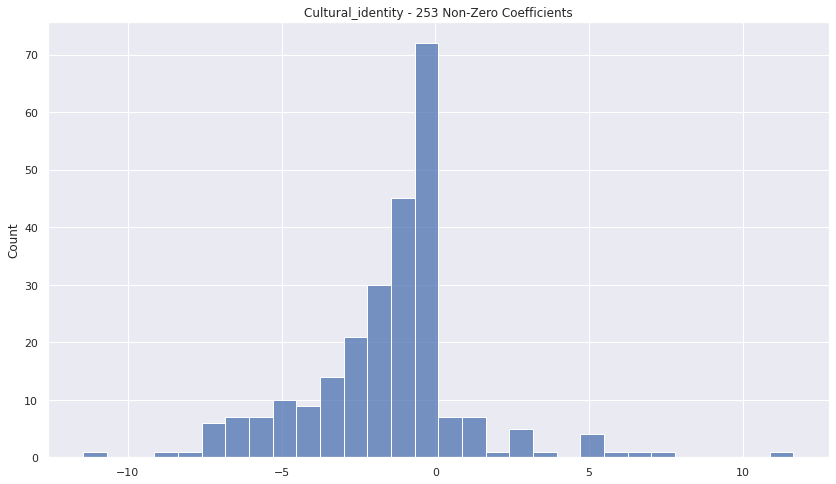

MicroF1:  0.5740561471442401
Positive:  ['iran nuclear' 'squeeze' 'tenuous' 'national commission' 'serbia'
 'board members' 'said longer' 'downed' 'launder' '244' 'formulating'
 'printer' 'article consider' '1956' 'spread far' 'discontinue'
 'policy change' 'underlined' 'health department' 'recess' 'childbearing'
 'economic advisers' 'study did' 'like world' 'jan 16' 'nih national'
 'study funded' 'trade agreement' 'atrocities' 'protocol']
Negative:  ['hodgkin lymphoma' 'family planning services' 'acutely aware'
 'really wanted' 'mass genocide' 'parasite' 'exposed virus' 'cares act'
 'used determine' 'infect human' 'prime minister benjamin' 'days weeks'
 'italian prime minister' 'body time' 'levin' 'time takes' 'february 2004'
 'stimulate' 'carefully crafted' 'pics' 'crushing' 'thousand years ago'
 'free enslavement matrix' 'join sorcha' 'age 19' 'heap' 'general john'
 'bavarian' 'law allows' 'continuing gratitude gem']


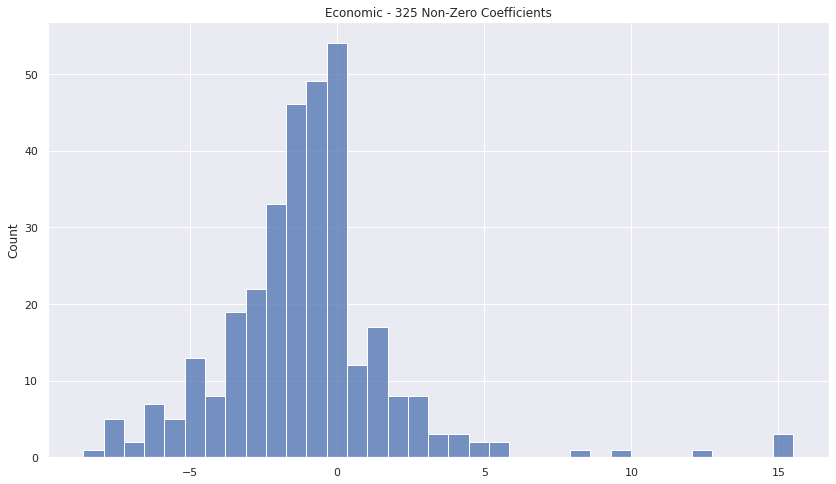

MicroF1:  0.6747868453105969
Positive:  ['iraqi leader saddam' 'referral' 'modified mosquitoes' 'berlin'
 'department public' 'october 19' 'study funded' 'malaysian' 'squeeze'
 'pascal' 'scientific literature' 'stressors' 'blindness'
 'senior executive' 'united states long' 'share information' 'lessons'
 'decrees' 'study did' 'parents child' 'nutritional' 'specific areas' 'ga'
 'technocracy' '1812' 'did mention' 'malign' 'great people' 'data says'
 'following statement']
Negative:  ['mass genocide' 'february 2004' 'manned space' 'celebrated'
 'hodgkin lymphoma' 'infect human' 'really wanted'
 'family planning services' 'law allows' 'non disclosure' 'time takes'
 'countries affected' 'cares act' 'build trust' 'concentration' 'outfit'
 'days attacks' 'used determine' 'needed year' 'people saying'
 'world health organization' 'usama bin laden' 'korean' 'body time' 'heap'
 'sheets' 'tumbled' 'changing climate' 'fluoride levels' 'glaring']


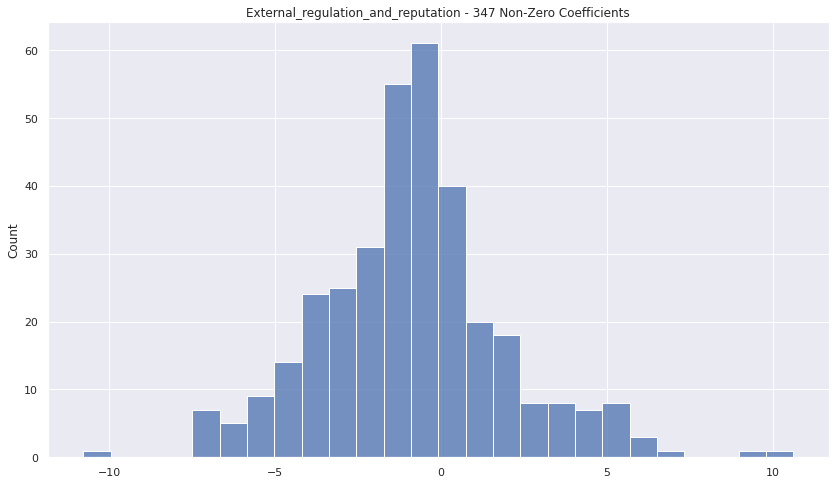

MicroF1:  0.18426501035196688
Positive:  ['choosing' 'corrections' 'concentration' 'particulars' 'feeders'
 'christmas' 'elliott' 'denials' 'tweaking' 'credible data' 'slap'
 'caught red handed' 'tips sun uk' 'non disclosure' '80s' 'spend billion'
 'warns' 'make happen' '850 000' 'car crash paris' 'harmed' 'ashamed' 'en'
 'caused novel' 'intercept' 'future studies' 'aug 31' 'nasa space'
 'drug available' 'hermann']
Negative:  ['levin' 'acutely aware' 'osteoporosis' 'manned space' 'join sorcha'
 'anti malarial' 'exposed virus' 'pea' 'hodgkin lymphoma'
 'pandemic influenza' 'security team' 'money money' 'february 2004'
 'plane said' 'report noted' '244' 'relocated' 'time takes'
 'people probably' 'president united states' 'policy initiatives' 'parade'
 'people condition' 'final' 'tumbled' 'infect human' 'change pfc bring'
 'unstoppable' 'children health' 'great britain']


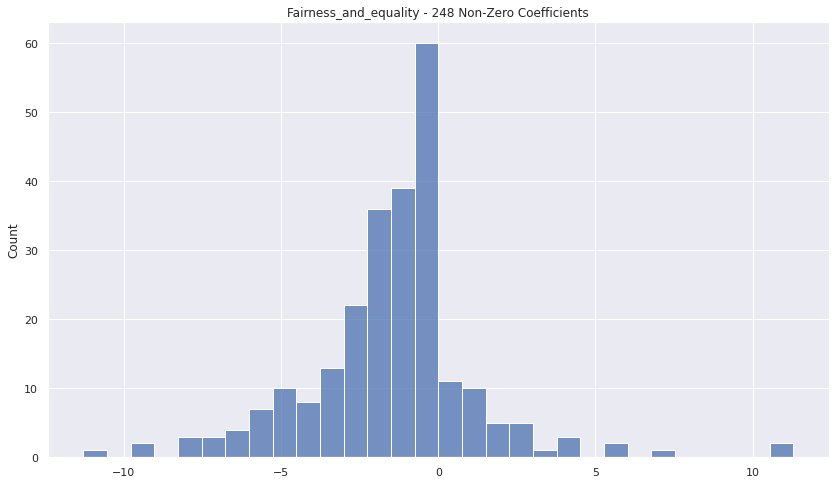

MicroF1:  0.8548171546592152
Positive:  ['levin' 'mass genocide' 'wage' 'infect human' 'osteoporosis' 'converging'
 'somatic' 'watch tv' 'guitarist' '890' 'kidney cells' 'debra' 'cares act'
 'people hiv aids' 'citizens catastrophic' '25 million'
 'financier george soros' 'condensation' 'usama bin laden'
 'used different' 'acrimonious' 'february 2004' 'baby parts'
 'change pfc bring' 'assange' 'smartphones' 'trump win' 'reached comment'
 'efforts cripple' 'defend']
Negative:  ['success story' 'national commission' 'squeeze' 'hesitancy'
 'caused novel' 'study funded' 'following statement' 'impossibility'
 'million miles' 'denials' 'bird' 'thyroid' 'based mind control'
 'used treat' 'senior executive' 'people especially' 'sculptor' '2025'
 'radiation therapy' 'mean time' 'concentration' 'compiled list'
 'skyrocketing' 'vengeance' 'present time' 'team university' 'flaperon'
 'tells story' 'lunch' 'technocracy']


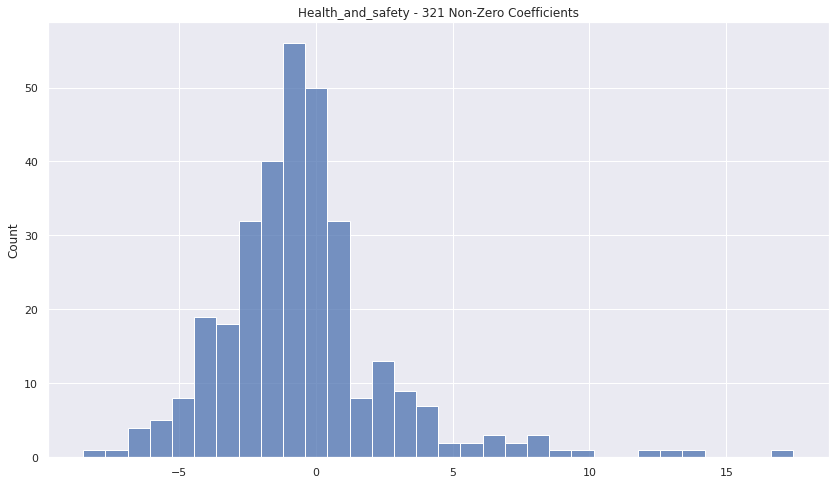

MicroF1:  0.5737544773689353
Positive:  ['anthem' 'million miles' 'success story' 'denials' 'possess' 'trusts'
 'fake' 'childish' 'george herbert walker' 'bystander' 'heavenly' 'levin'
 'sickened' 'psychologists' 'mrs bush' 'turkish president'
 'state hillary clinton' 'referral' 'ratification' 'salty' 'madness'
 'gulf region' 'crown' 'lessons' 'association british'
 'address climate change' 'aisle' 'worked cia' 'nominate'
 'senior administration']
Negative:  ['walters' 'hodgkin lymphoma' 'manned space' 'thousand years ago'
 'people saying' 'february 2004' 'family planning services'
 'according internal' 'pea' 'really wanted' 'taller' 'infect human'
 'present time' 'iran nuclear' 'sheets' 'sheep' 'mass genocide'
 'iterations' 'needed year' 'testifying' 'time takes' 'helpline' 'sony'
 'steve bannon' 'miami' 'president united states' 'died heart failure'
 'credit card' 'carefully crafted' 'harbor']


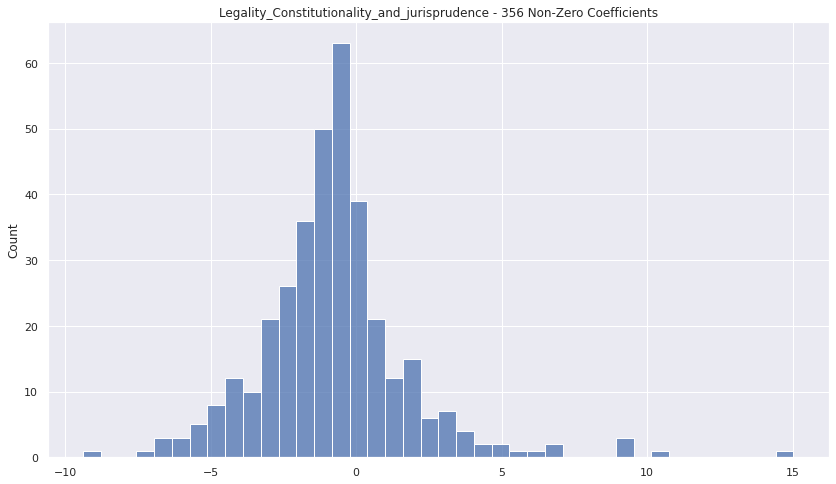

MicroF1:  0.6263945578231292
Positive:  ['tower world trade' 'perpetrated' 'caused novel' 'ecuador' 'corrosive'
 'success story' 'denials' 'los angeles police' 'backers' 'proportions'
 'strong' 'spend billion' 'intercept' 'nominate' 'research suggests'
 'order avoid' 'late 2017' 'electroshock' 'pittsburgh' 'saying let'
 'temperature changes' 'south west' 'en' 'mcbride' 'trump win'
 'air temperature' 'people use' '80s' 'lateral' '2025']
Negative:  ['converging' 'plane said' 'levin' '890' 'enhancing' 'inner'
 'music videos' 'acutely aware' 'tuesday' 'student loan' 'rag'
 'really wanted' 'countries risk' 'alkaline' 'february 2004'
 'exampled numerous' 'great britain' 'pandemic influenza' 'guitarist'
 'sheets' 'sculptor' 'infect human' 'carol' 'continuing gratitude gem'
 'various ways' 'states year' 'matthews' 'time takes' 'internal organs'
 '105']


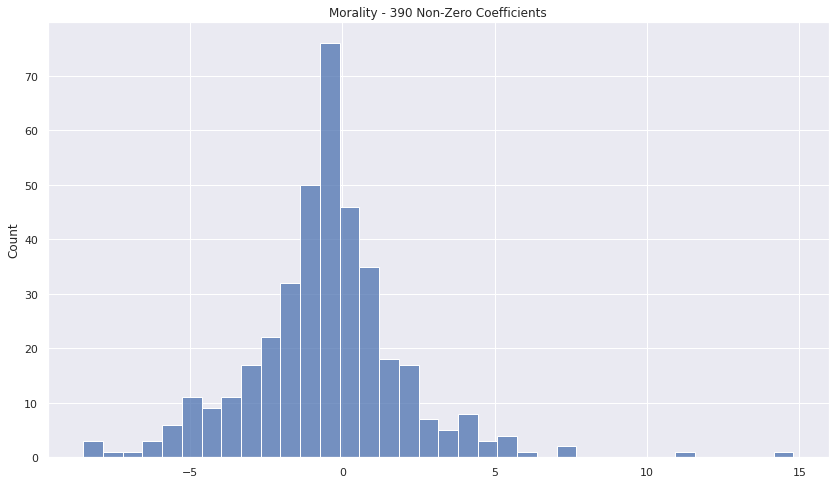

MicroF1:  0.3986674069961133
Positive:  ['lessons' 'heavenly' '2025' 'implausible' 'sharing article' 'summary'
 'squeeze' 'label conceived' 'eastern drc' 'way government'
 'returning normal' 'created donated sisters' 'salty' 'ownership'
 'feasible' 'colleagues' 'said longer' 'referral' 'economic advisers'
 'board members' 'time used' 'judge michael' 'nutritional' 'haley'
 'disability' 'ga' 'transactions' 've really' 'deepening' 'aisle']
Negative:  ['mass genocide' 'infect human' 'people saying' 'osteoporosis'
 'people infected virus' 'family planning services' 'sheep'
 'real question' 'february 2004' 'usama bin laden' 'cares act'
 'used different' 'needed year' 'thousand years ago' 'flaperon'
 'hodgkin lymphoma' 'profoundly' 'pics' 'inner' 'man giant' 'loathing'
 'really wanted' 'sony' 'law allows' 'given drug' 'italian prime minister'
 'earmarked' 'money money' 'european leaders' 'fluoride levels']


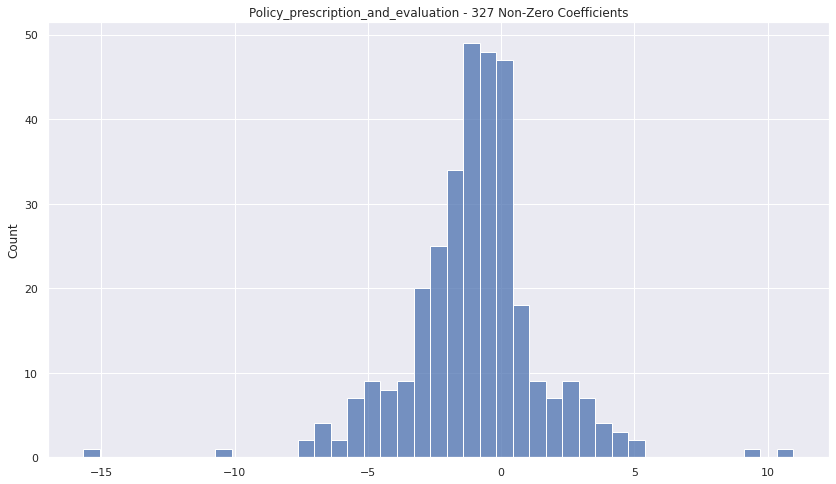

MicroF1:  0.784835652349264
Positive:  ['decrees' 'following statement' 'far flung' 'haley' 'parents child'
 'basket' 'october 19' 'lessons' 'poster' 'fame fortune'
 'economic advisers' 'iran nuclear' 'music festival' 'pascal'
 'afford send' 'order follow' 'referral' 'unease' 'freedom fighters'
 'specific areas' 'cement' 'lakh' 'science technology' 'regional'
 'suicide bombers' 'study funded' 'sex partner' 'ratios' 'offended'
 'able maintain']
Negative:  ['hodgkin lymphoma' 'used different' 'february 2004'
 'financier george soros' 'days attacks' 'really wanted' 'used determine'
 'infect human' 'free enslavement matrix' 'perpetrated' 'mass genocide'
 'outfit' 'change pfc bring' 'towers' 'man giant' 'inner' 'fostering'
 'korean' 'president united states' 'sheets' 'plane said' 'unstoppable'
 'straight line' 'sheep' 'build trust' 'tumbled' 'people saying' 'word'
 'time takes' 'counterparts']


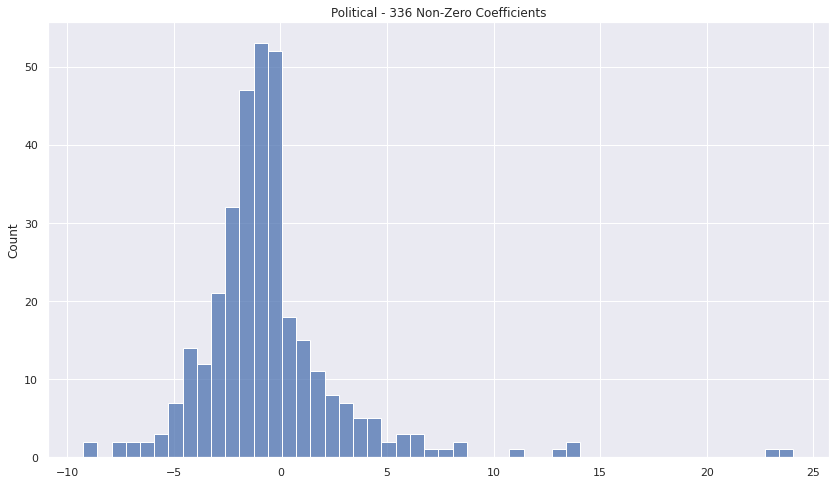

MicroF1:  0.058823529411764705
Positive:  ['stimulus package' 'amounts money' 'following statement' 'parasite'
 'gasoline prices' 'swam' 'panic buying' 'countering' 'quaint'
 'afford send' 'merge' 'trump won' 'defund planned' 'faith based'
 'women abortions' 'planning programs' 'federally funded'
 'anti abortion activists' 'administration issued'
 'president planned parenthood' 'planned parenthood federation' 'marjorie'
 'slush' 'applauded' 'federation' 'wen' 'leana'
 'parenthood federation america' 'prohibits' 'imposing']
Negative:  ['days attacks' 'family planning services' 'used determine'
 'pandemic influenza' 'manned space' 'levin' 'people saying'
 'infect human' 'pea' 'join sorcha' 'according internal' 'pics'
 'relocated' 'exposed virus' 'thousand years ago' 'days weeks' 'sony'
 'ono' 'herbert walker bush' 'usama bin laden' 'tumbled' 'counterparts'
 'countries risk' 'central africa' 'eyes nose mouth' 'unstoppable'
 'watch tv' 'energy energy' '25 million' 'outfit']


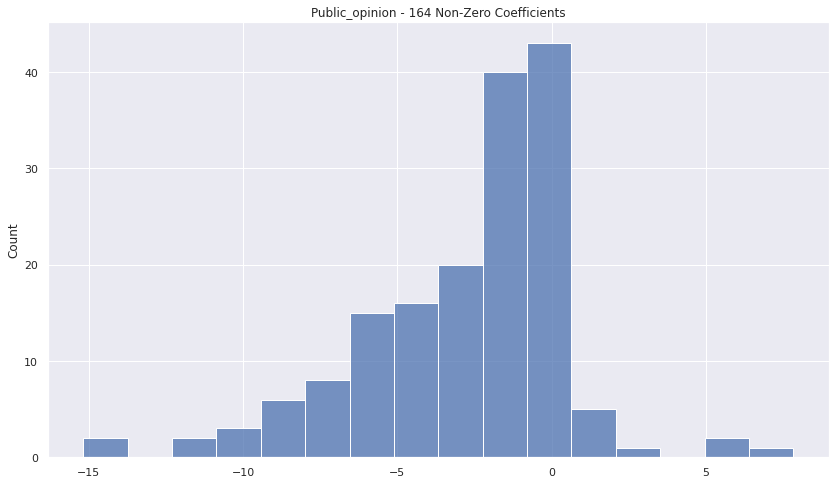

MicroF1:  0.8491875423155044
Positive:  ['parade' 'dreamy' 'mass genocide' '24 hours' 'myth' 'ahmed'
 'iran nuclear' 'wage' 'february 2004' 'miami' 'detects' 'levin'
 'nearly 000' 'acutely aware' 'warned world' 'days attacks' 'sheep'
 'osteoporosis' 'order ensure' 'rumoured' 'board members' '1866' 'outfit'
 'infect human' 'nih national' 'insomnia' 'national commission'
 'wars iraq' 'guitarist' 'response ebola outbreak']
Negative:  ['decrees' 'parasite' 'parents child' 'serial killer' 'technocracy'
 'search missing' 'world records' 'italian prime minister' 'help lower'
 'office national' 'macron' 'profoundly' 'ecuador' 'vaccinated' 'swirled'
 'central africa' 'eviction' 'success story' 'following statement'
 'mick jagger' 'invocation' 'referral' 'poster' 'harmed' 'shock'
 'nominate' 'trusts' 'months years' 'berlin' 'drug war']


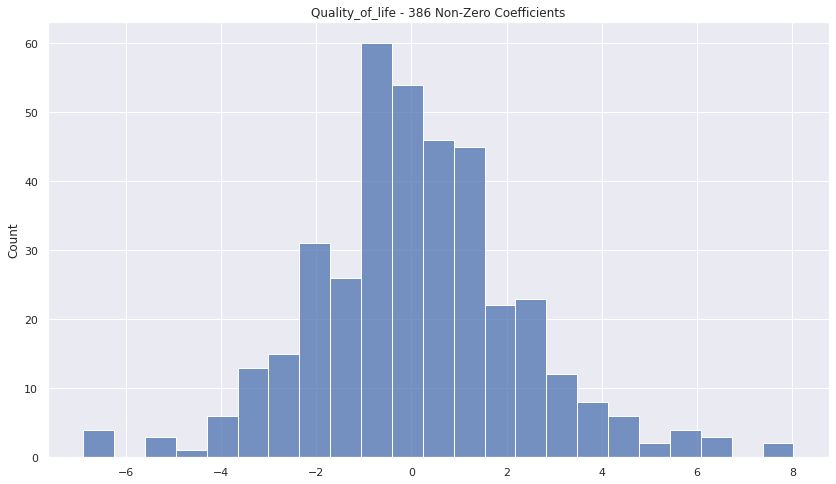

MicroF1:  0.6828834173835657
Positive:  ['meets eye' 'study funded' 'search missing' 'trump win' 'macron'
 'children health' 'swirled' 'just finished' 'technocracy' 'marian'
 'american space' 'governs' 'harbor' 'extremes' 'economic crashes'
 'covert american' 'lemon' 'september 2019' 'modified mosquitoes'
 'concentrating' 'skin cancer' 'disease spreading' 'oral health'
 'june 2011' 'cases diagnosed' 'inner' 'transplants' 'psychiatrists'
 'opposition' 'abstraction']
Negative:  ['bird' 'electroshock' 'justifiably' 'lessons' 'notoriously' 'lateral'
 'mass genocide' 'aisle' 'non disclosure' 'national commission'
 'perpetrated' 'herbert walker bush' 'milo' 'unease' '237'
 'science technology' 'oceanic atmospheric' 'lakh' 'law allows' '2025'
 'parade' 'search alien' 'regional' 'sane' 'like world' 'campaigns'
 'gm products' 'markedly' 'real question' 'merge']


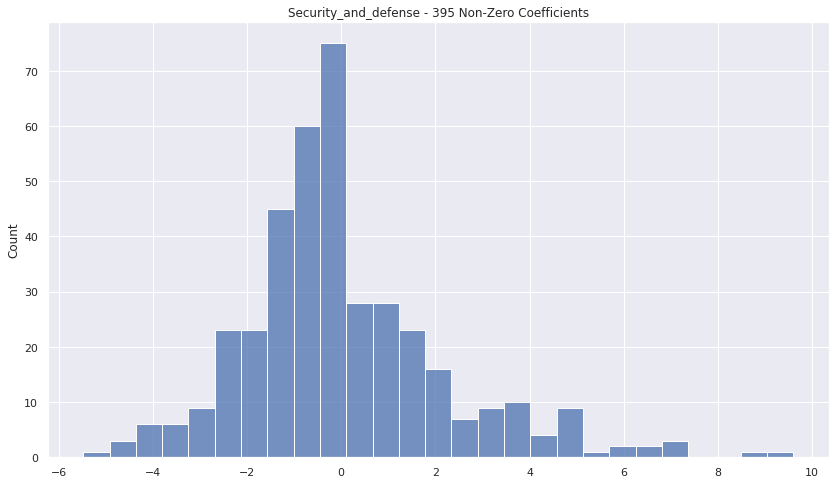

In [14]:
topic_frame = []
positive_words = []
negative_words = []
scores = []
n_words = 30
for cat in categories:
    p, n, score = calculate_feature_importance(X, dfs['data'][cat], vocabulary, cat, min_coefficient=0.1)
    positive_words.append(p)
    negative_words.append(n)
    scores.append(score)
    topic_frame.append(p[:n_words])

In [15]:
max_idxs = np.argsort(scores)[::-1]
for frame in max_idxs:
    line = f"{re.sub('_', ' ', categories[frame])} & {', '.join(topic_frame[frame][:15])} & {scores[frame]:4.2f} \\\\"
    print(line)

Health and safety & levin, mass genocide, wage, infect human, osteoporosis, converging, somatic, watch tv, guitarist, 890, kidney cells, debra, cares act, people hiv aids, citizens catastrophic & 0.85 \\
Quality of life & parade, dreamy, mass genocide, 24 hours, myth, ahmed, iran nuclear, wage, february 2004, miami, detects, levin, nearly 000, acutely aware, warned world & 0.85 \\
Political & decrees, following statement, far flung, haley, parents child, basket, october 19, lessons, poster, fame fortune, economic advisers, iran nuclear, music festival, pascal, afford send & 0.78 \\
Crime and punishment & foot long, shock, vulnerability, 25 30, straight line, success story, sifting, federal law, strong, previous record, services committee, help lower, live virus, 891, madness & 0.71 \\
Security and defense & meets eye, study funded, search missing, trump win, macron, children health, swirled, just finished, technocracy, marian, american space, governs, harbor, extremes, economic crashes

In [16]:
tokenizer = lambda s: re.findall( '\w+', s.lower() )
texts = [tokenizer(t) for t in  dfs['data'].txt]
dictionary = Dictionary(texts)

In [17]:
cm = CoherenceModel(topics=topic_frame,
                    texts=texts,
                    coherence='c_v',
                    dictionary=dictionary)
coherence_per_topic_frame = cm.get_coherence_per_topic()

In [18]:
data_topic_score_frame = pd.DataFrame(data=zip(categories, coherence_per_topic_frame), columns=['Topic', 'Coherence'])
data_topic_score_frame = data_topic_score_frame.set_index('Topic')

0.5889630771845262


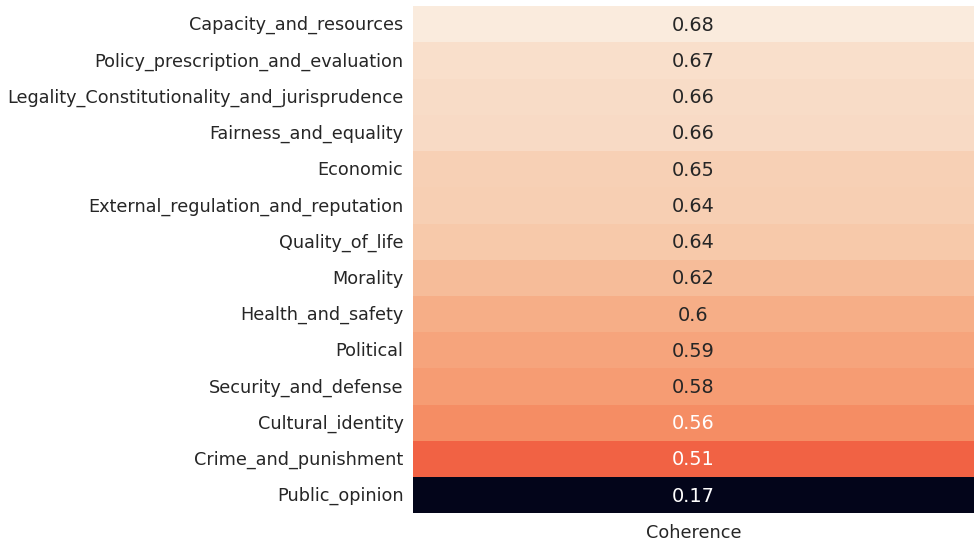

In [19]:
sns.set(font_scale=1.6)
sns.heatmap(data=data_topic_score_frame.sort_values(by='Coherence', ascending=False), annot=True, cbar=False).set(xlabel='', ylabel='')
plt.tight_layout()
print(np.mean(data_topic_score_frame.Coherence))
sns.set(font_scale=1)

# BertTopic

In [20]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
from nltk.corpus import stopwords
vectorizer_model = CountVectorizer(stop_words=stopwords.words('english'))
topic_model = BERTopic(vectorizer_model=vectorizer_model)

In [22]:
%%time
with open('data/LOCO/LOCO_mpnet_embeddings.pickle', 'rb') as f:
    embeddings = pickle.load(f)
topic_model.fit(dfs['data'].txt, embeddings)

CPU times: user 1min 33s, sys: 2.37 s, total: 1min 35s
Wall time: 48.8 s


In [23]:
topics = []
for topic in list(topic_model.get_topics().values()):
    words = [word_score[0] for word_score in topic]
    topics.append(words)

In [24]:
cm = CoherenceModel(topics=topics,
                    texts=texts,
                    coherence='c_v',  
                    dictionary=dictionary)
coherence_per_topic = cm.get_coherence_per_topic()

In [25]:
data_topic_score = pd.DataFrame(data=zip(topic_model.topic_labels_.values(), coherence_per_topic), columns=['Topic', 'Coherence'])
data_topic_score = data_topic_score.set_index('Topic')

0.6520152036968911


<AxesSubplot: ylabel='Topic'>

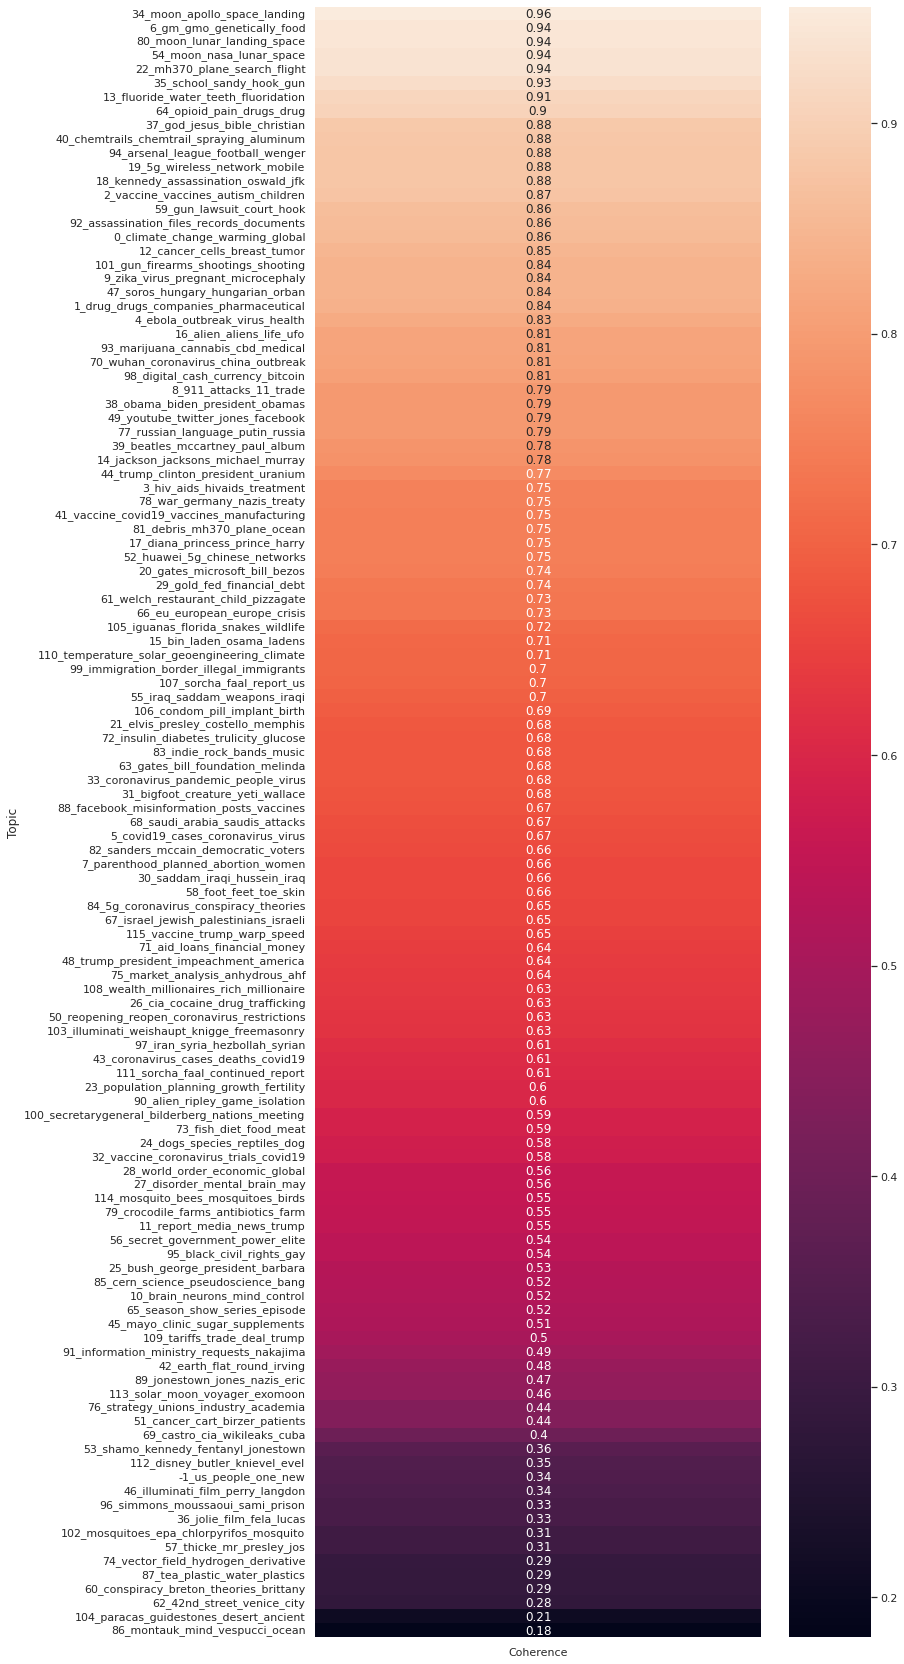

In [26]:
print(np.mean(data_topic_score.Coherence))
fig, ax = plt.subplots(figsize=(10, 30))
sns.set(font_scale=1)
sns.heatmap(data=data_topic_score.sort_values(by='Coherence', ascending=False), annot=True, ax=ax)

In [27]:
%%time
topic_model_reduced = BERTopic(vectorizer_model=vectorizer_model, nr_topics=14)
topic_model_reduced.fit(dfs['data'].txt, embeddings)

CPU times: user 1min 32s, sys: 2.77 s, total: 1min 35s
Wall time: 39.4 s


In [28]:
topics_reduced = []
for topic in list(topic_model_reduced.get_topics().values()):
    words = [word_score[0] for word_score in topic]
    topics_reduced.append(words)

In [29]:
cm = CoherenceModel(topics=topics_reduced,
                    texts=texts,
                    coherence='c_v',  
                    dictionary=dictionary)
coherence_per_topic_topic = cm.get_coherence_per_topic()

In [30]:
data_topic_score_topic = pd.DataFrame(data=zip(topic_model_reduced.topic_labels_.values(), coherence_per_topic_topic), columns=['Topic', 'Coherence'])
data_topic_score_topic = data_topic_score_topic.set_index('Topic')

0.5584925487780776


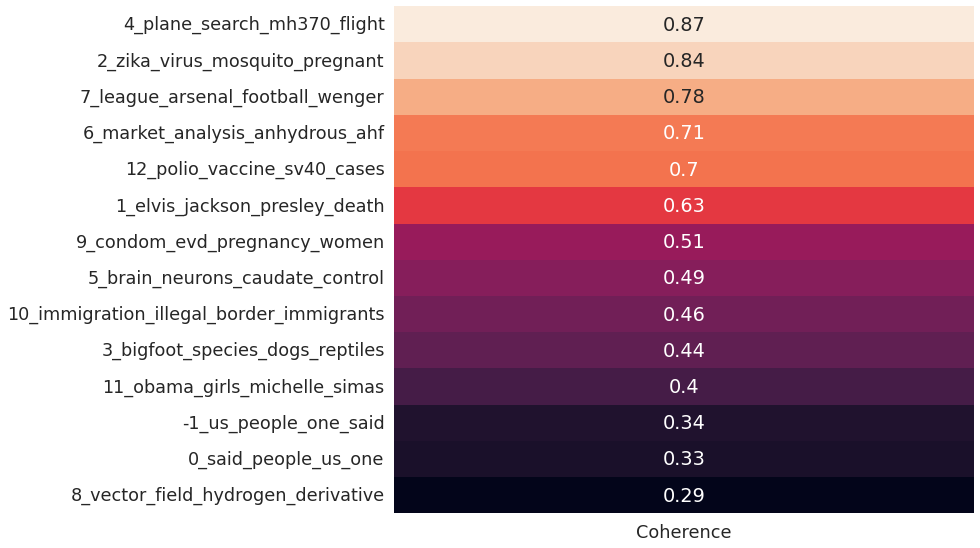

In [31]:
sns.set(font_scale=1.6)
sns.heatmap(data=data_topic_score_topic.sort_values(by='Coherence', ascending=False), annot=True, cbar=False).set(xlabel='', ylabel='')
plt.tight_layout()
print(np.mean(data_topic_score_topic.Coherence))

0.5889630771845262
0.5584925487780776


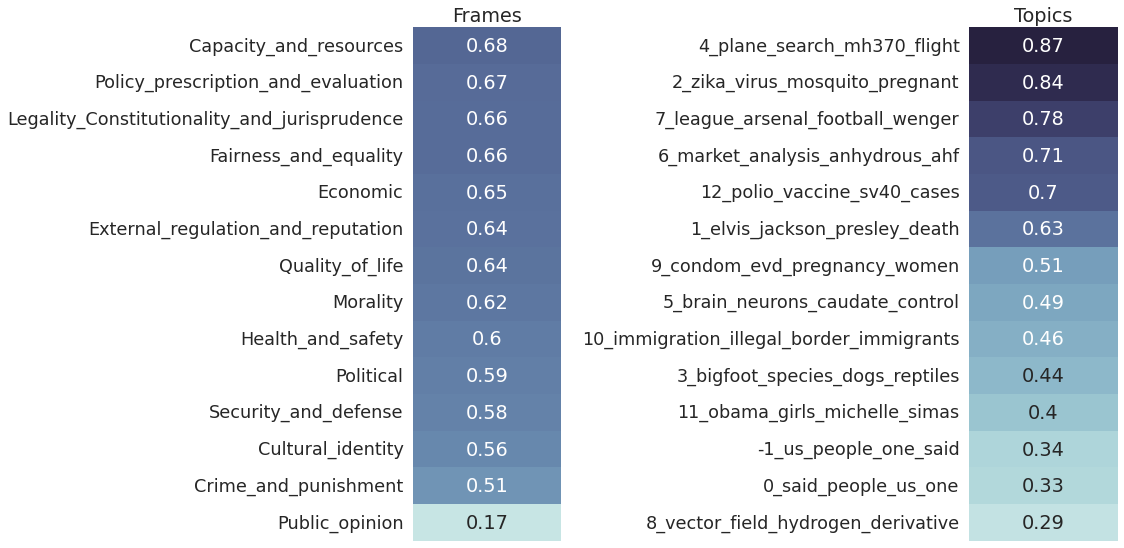

In [32]:
sns.set(font_scale=1.6)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(
    data=data_topic_score_frame.sort_values(by='Coherence', ascending=False),
    annot=True,
    cbar=False,
    xticklabels='',
    cmap=sns.color_palette("ch:start=.2,rot=-.3,dark=.4,light=.86", as_cmap=True),
    ax=axs[0]).set(ylabel='', title='Frames')
sns.heatmap(
    data=data_topic_score_topic.sort_values(by='Coherence', ascending=False),
    annot=True,
    cbar=False,
    xticklabels='',
    cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True),
    ax=axs[1]).set(ylabel='', title='Topics')
plt.tight_layout()
print(np.mean(data_topic_score_frame.Coherence))
print(np.mean(data_topic_score_topic.Coherence))
#plt.savefig('figures/coherence.pdf')

In [33]:
from sklearn.cluster import KMeans

cluster_model = KMeans(n_clusters=30)
topic_model_kmeans = BERTopic(vectorizer_model=vectorizer_model, hdbscan_model=cluster_model)
topic_model_kmeans.fit(dfs['data'].txt, embeddings)

In [34]:
topics_kmeans = []
for topic in list(topic_model_kmeans.get_topics().values()):
    words = [word_score[0] for word_score in topic]
    topics_kmeans.append(words)

In [35]:
cm = CoherenceModel(topics=topics_kmeans,
                    texts=texts,
                    coherence='c_v',  
                    dictionary=dictionary)
coherence_per_topic_kmeans = cm.get_coherence_per_topic()

In [36]:
data_topic_score_kmeans = pd.DataFrame(data=zip(topic_model_kmeans.topic_labels_.values(), coherence_per_topic_kmeans), columns=['Topic', 'Coherence'])
data_topic_score_kmeans = data_topic_score_kmeans.set_index('Topic')

0.6692187706298982


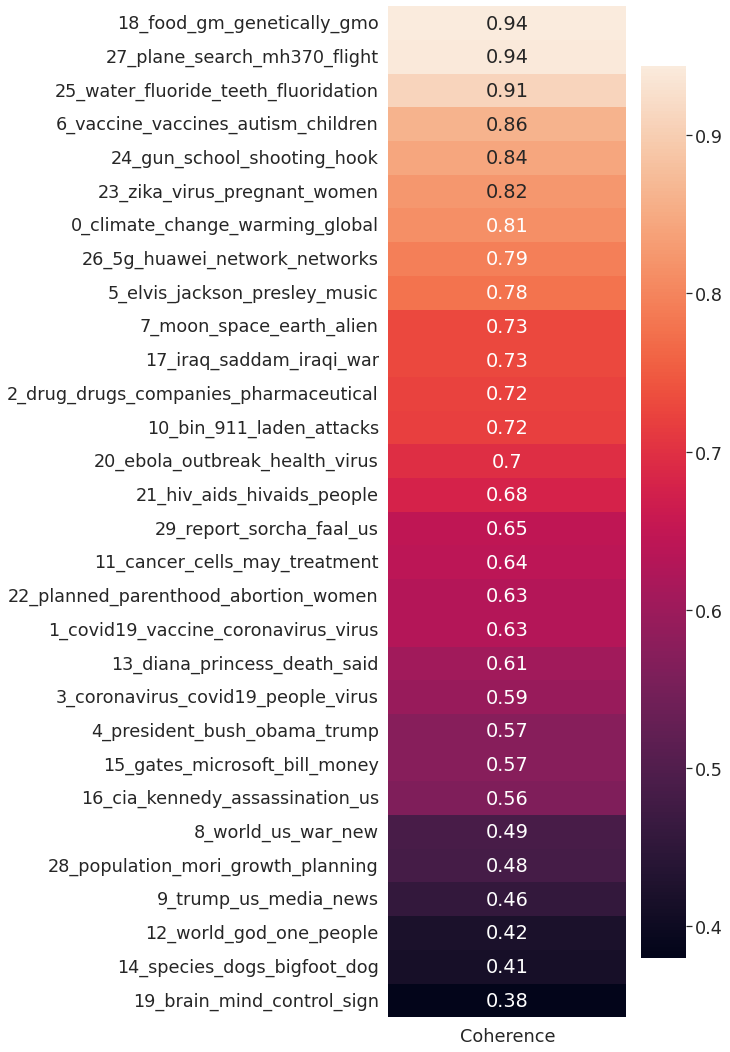

In [37]:
fig, ax = plt.subplots(figsize=(10, 15))
sns.set(font_scale=1.6)
sns.heatmap(data=data_topic_score_kmeans.sort_values(by='Coherence', ascending=False), annot=True, ax=ax).set(xlabel='', ylabel='')
plt.tight_layout()
print(np.mean(data_topic_score_kmeans.Coherence))

In [38]:
topic_model_kmeans.get_topics()

{0: [('climate', 0.04321137071631388),
  ('change', 0.026190235459141346),
  ('warming', 0.02099169986611863),
  ('global', 0.018565447551985293),
  ('emissions', 0.012298728544815238),
  ('energy', 0.0118295962325432),
  ('carbon', 0.010910434390266078),
  ('temperature', 0.009074535967755558),
  ('weather', 0.008764005455881284),
  ('water', 0.008630517175846656)],
 1: [('covid19', 0.03381173152589493),
  ('vaccine', 0.025307132699736886),
  ('coronavirus', 0.020089633410815978),
  ('virus', 0.0164270926970436),
  ('health', 0.014187717582889666),
  ('people', 0.013903624413143651),
  ('said', 0.012771409414306784),
  ('patients', 0.012423376060153505),
  ('pandemic', 0.011200226477982845),
  ('cases', 0.01070203416039807)],
 2: [('drug', 0.033520425635240374),
  ('drugs', 0.02543363763481072),
  ('companies', 0.01919532754525559),
  ('pharmaceutical', 0.017737174790349364),
  ('health', 0.013889002013196216),
  ('industry', 0.013684978043958086),
  ('prices', 0.011504332395095346),


# Correlations

In [39]:
dfs['data']['Topic'] = topic_model.get_document_info(dfs['data'].txt).Topic
dfs['data']['TopicReduced'] = topic_model_reduced.get_document_info(dfs['data'].txt).Topic
dfs['data']['TopicKMeans'] = topic_model_kmeans.get_document_info(dfs['data'].txt).Topic

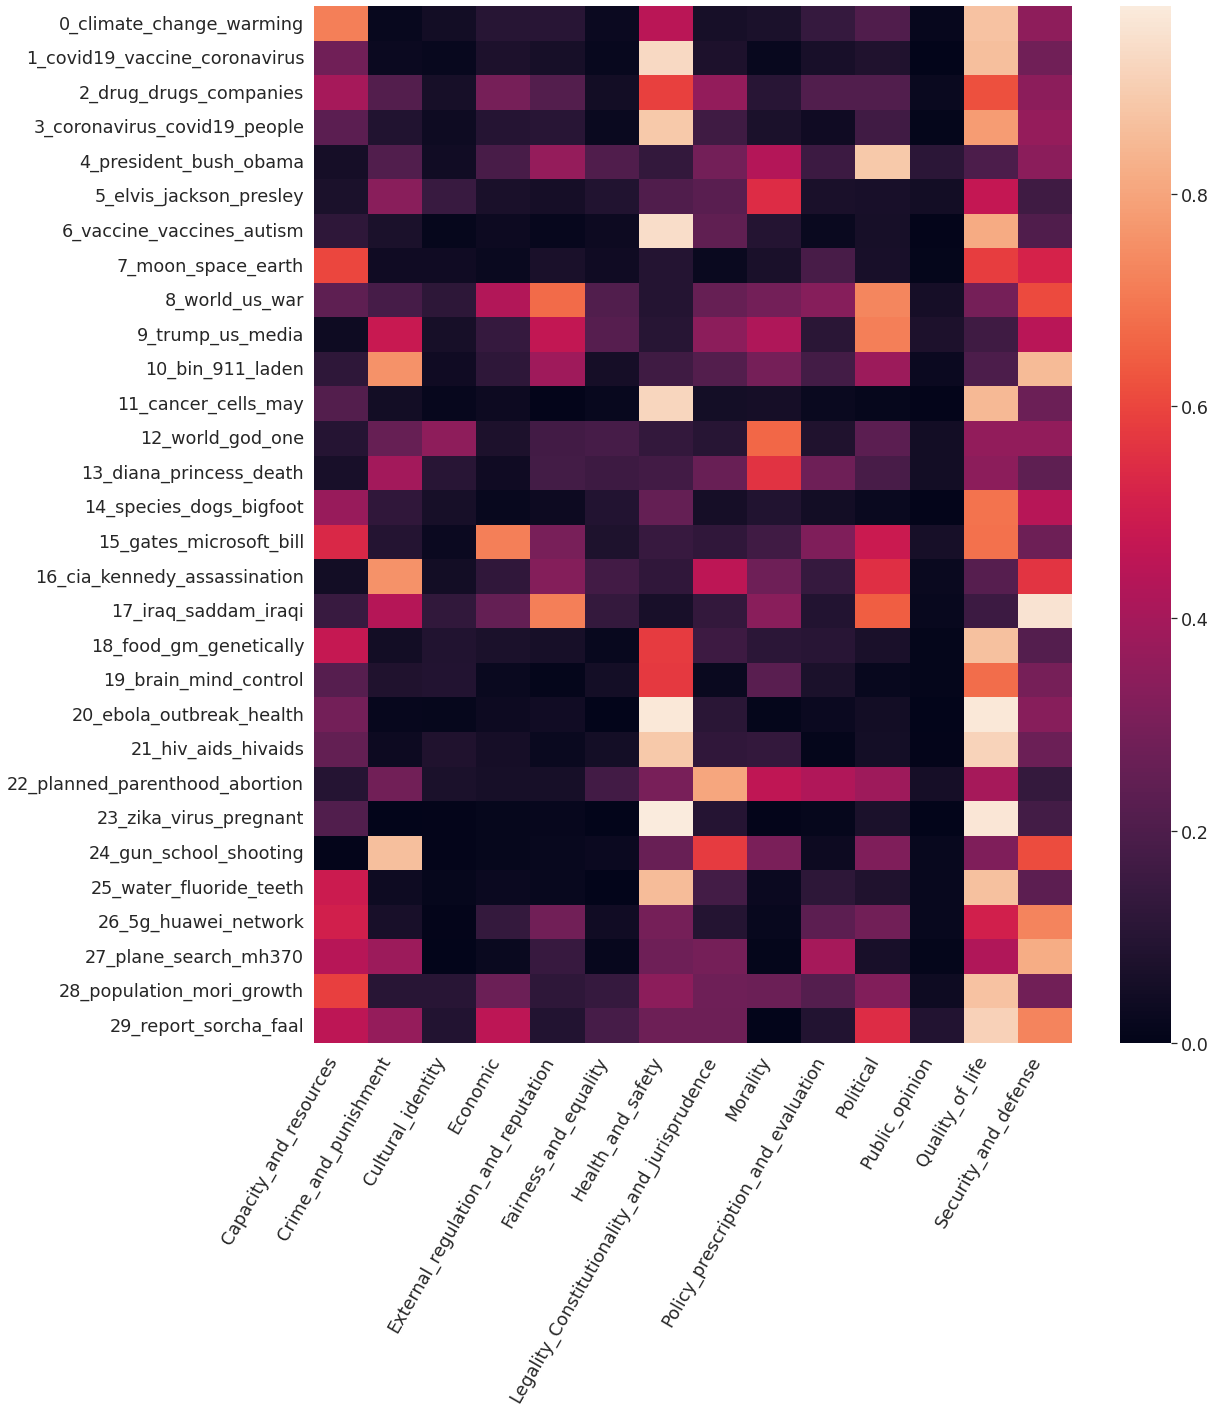

In [43]:
# P(frame|narrative)
cooccurrences = np.dot(pd.get_dummies(dfs['data'].TopicKMeans).to_numpy().T, dfs['frames'].to_numpy())
cooccurrences_topic_norm = (cooccurrences.T / dfs['data'].TopicKMeans.value_counts().to_numpy()).T
sns.set(font_scale=1.6)
fig, ax = plt.subplots(figsize=(18, 20))
heatmap = sns.heatmap(
    cooccurrences_topic_norm,
    xticklabels=dfs['frames'].columns,
    yticklabels=topic_model_kmeans.generate_topic_labels(),
    #cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True),
    ax=ax
)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=60, horizontalalignment='right')
plt.tight_layout()
#plt.savefig('figures/topic_frame_correlation_kmeans30_normtopics.pdf')

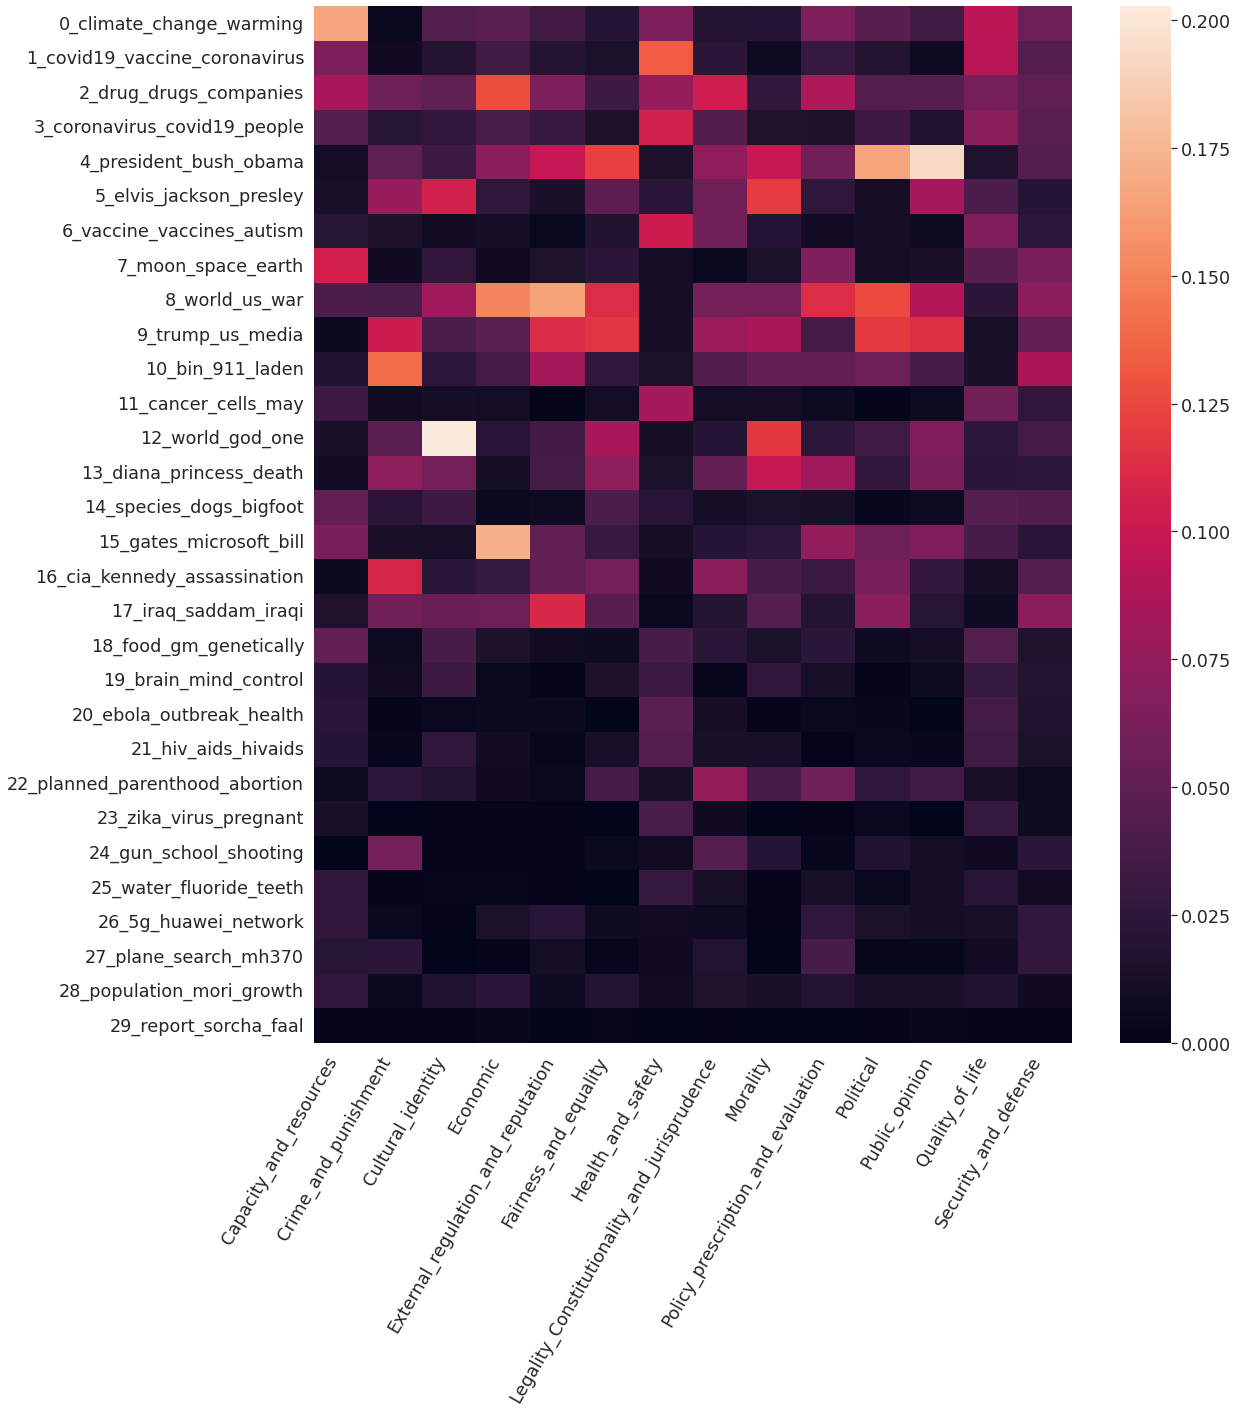

In [44]:
# P(narrative|frame)
cooccurrences = np.dot(pd.get_dummies(dfs['data'].TopicKMeans).to_numpy().T, dfs['frames'].to_numpy())
cooccurrences_frame_norm = cooccurrences / dfs['frames'].sum().to_numpy()
fig, ax = plt.subplots(figsize=(18, 20))
heatmap = sns.heatmap(
    cooccurrences_frame_norm,
    xticklabels=dfs['frames'].columns,
    yticklabels=topic_model_kmeans.generate_topic_labels()
)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=60, horizontalalignment='right')
plt.tight_layout()
#plt.savefig('figures/topic_frame_correlation_kmeans30.pdf')

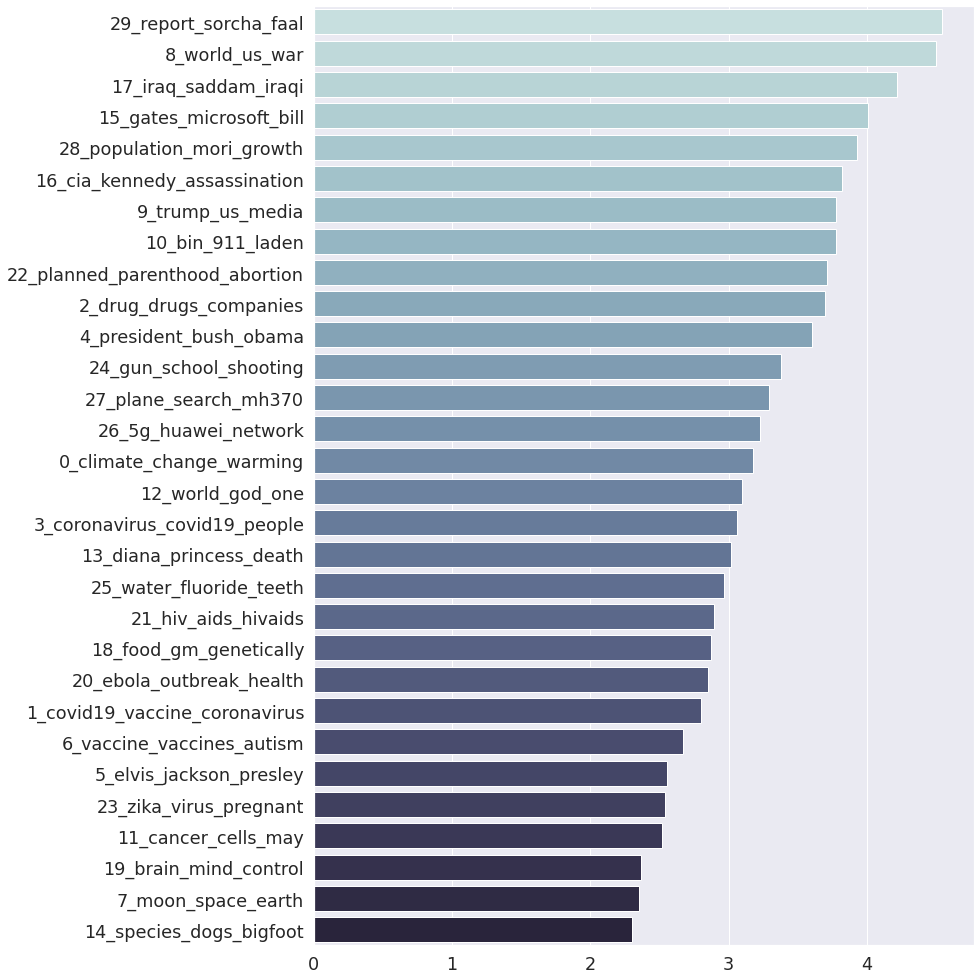

In [45]:
plt.subplots(figsize=(14, 14))
order = np.argsort(cooccurrences_topic_norm.sum(axis=1))[::-1]
sns.barplot(
    x=cooccurrences_topic_norm.sum(axis=1)[order],
    y=np.array(topic_model_kmeans.generate_topic_labels())[order],
    orient='h',
    palette=sns.cubehelix_palette(start=.2, rot=-.3, n_colors=30),
)
plt.tight_layout()
#plt.savefig('figures/num_frames.pdf')

In [46]:
topic_model_kmeans.get_topic(11)

[('cancer', 0.059986774671976786),
 ('cells', 0.02140589720437374),
 ('may', 0.016034189607368656),
 ('treatment', 0.015346591040039227),
 ('patients', 0.013679750899552664),
 ('breast', 0.012171668407097007),
 ('blood', 0.010900420547356883),
 ('cell', 0.010793232534050002),
 ('risk', 0.010203656687811096),
 ('also', 0.01008571234879194)]

<AxesSubplot: >

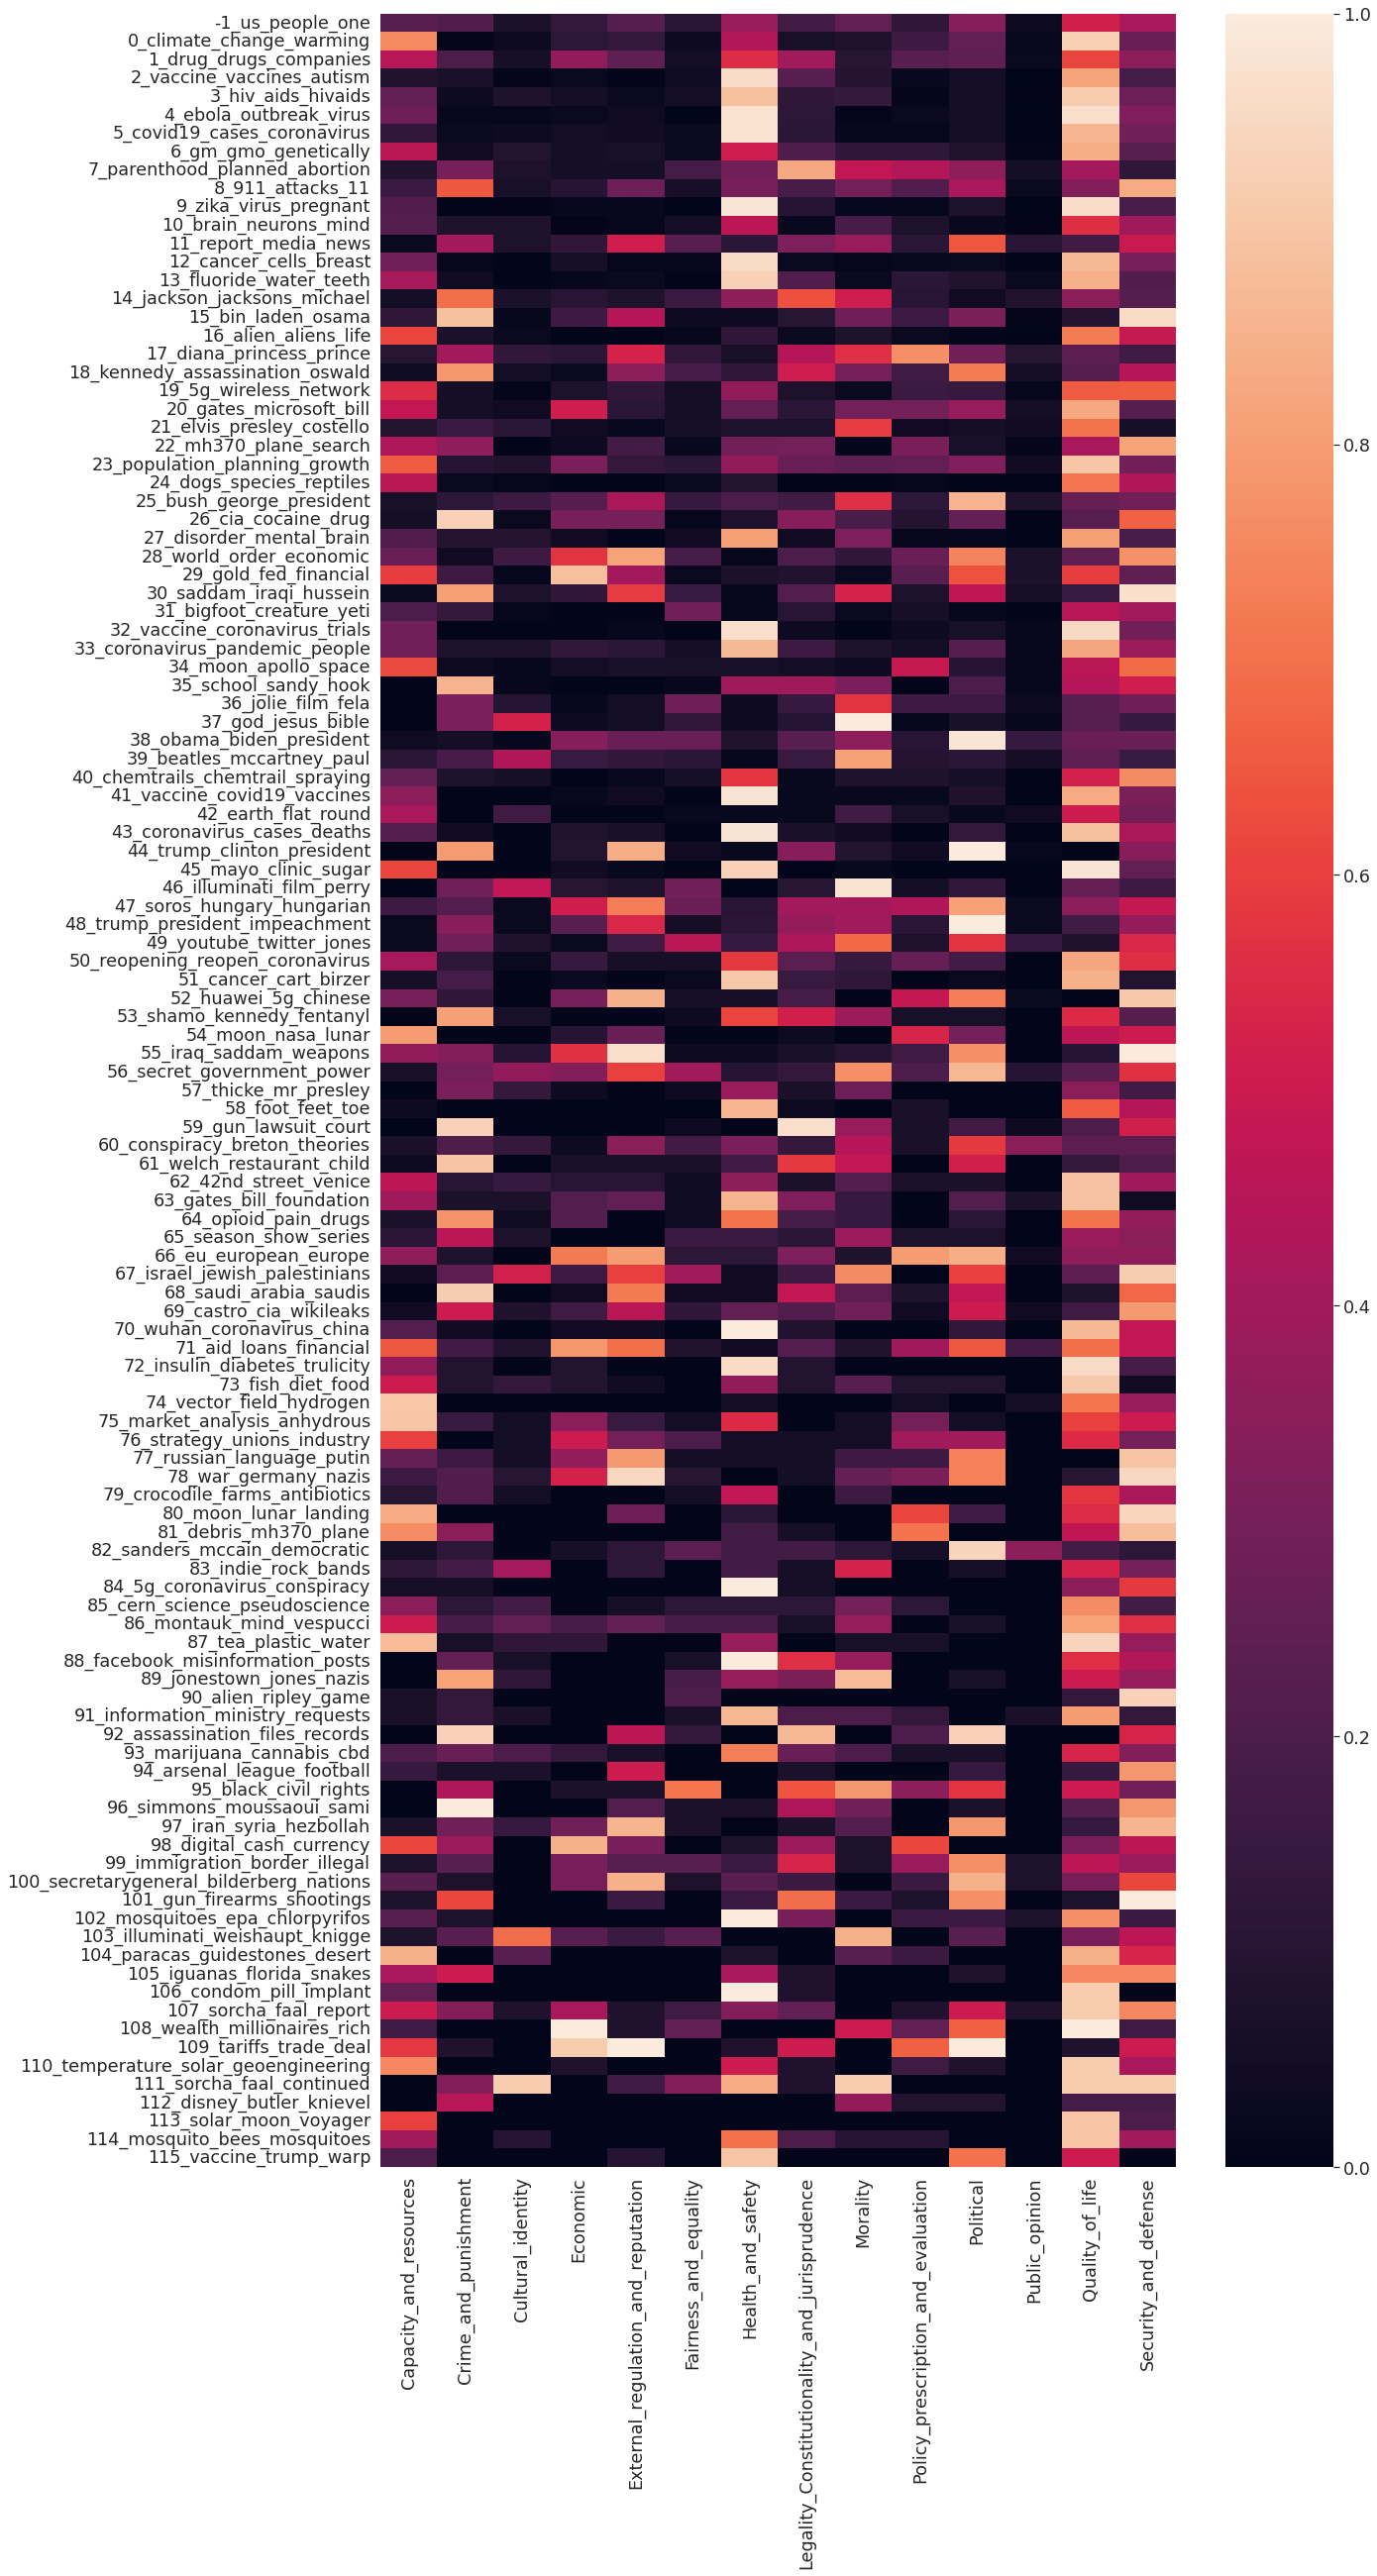

In [47]:
cooccurrences = np.dot(pd.get_dummies(dfs['data'].Topic).to_numpy().T, dfs['frames'].to_numpy())
cooccurrences_topic_norm = (cooccurrences.T / dfs['data'].Topic.value_counts().to_numpy()).T
fig, ax = plt.subplots(figsize=(18, 40))
sns.heatmap(
    cooccurrences_topic_norm,
    xticklabels=dfs['frames'].columns,
    yticklabels=topic_model.generate_topic_labels(),
    ax=ax
)

In [48]:
max_polarized_topic_idxs = np.argsort(cooccurrences_topic_norm.sum(1))[::-1]
np.array(topic_model.generate_topic_labels())[max_polarized_topic_idxs[:20]]

array(['109_tariffs_trade_deal', '111_sorcha_faal_continued',
       '71_aid_loans_financial', '56_secret_government_power',
       '66_eu_european_europe', '47_soros_hungary_hungarian',
       '67_israel_jewish_palestinians', '55_iraq_saddam_weapons',
       '107_sorcha_faal_report', '28_world_order_economic',
       '78_war_germany_nazis', '95_black_civil_rights',
       '30_saddam_iraqi_hussein', '23_population_planning_growth',
       '108_wealth_millionaires_rich', '98_digital_cash_currency',
       '92_assassination_files_records', '29_gold_fed_financial',
       '17_diana_princess_prince', '52_huawei_5g_chinese'], dtype='<U39')

In [49]:
max_polarized_topic_idxs = np.argsort(cooccurrences_topic_norm.var(1))[::-1]
np.array(topic_model.generate_topic_labels())[max_polarized_topic_idxs[:20]]

array(['111_sorcha_faal_continued', '109_tariffs_trade_deal',
       '92_assassination_files_records', '108_wealth_millionaires_rich',
       '45_mayo_clinic_sugar', '44_trump_clinton_president',
       '55_iraq_saddam_weapons', '106_condom_pill_implant',
       '101_gun_firearms_shootings', '32_vaccine_coronavirus_trials',
       '4_ebola_outbreak_virus', '80_moon_lunar_landing',
       '59_gun_lawsuit_court', '9_zika_virus_pregnant',
       '72_insulin_diabetes_trulicity', '78_war_germany_nazis',
       '70_wuhan_coronavirus_china', '81_debris_mh370_plane',
       '52_huawei_5g_chinese', '43_coronavirus_cases_deaths'],
      dtype='<U39')